In [154]:
import glob
import os
import csv
import numpy as np
from scipy.signal import medfilt
from scipy.signal import wiener
from scipy.signal import savgol_filter

genders = ['male', 'female']
labels = ['Happy', 'Surprise', 'Disgust', 'Angry', 'Fear', 'Sad', 'Neutral'] # 0-6, 7 classes

def preprocess_data(dataPath, train):
    if train:
        path = os.path.join(dataPath, 'train')
        output_dir = os.path.join(dataPath, 'train.csv')
    else:
        path = os.path.join(dataPath, 'val')
        output_dir = os.path.join(dataPath, 'val.csv')
    folders = glob.glob(os.path.join(path, '*'))
    folders.sort()

    with open(output_dir, 'a+') as csv_output_file:
        fieldnames = ['User', 'Person_min', 'Max', 'Min', 'Mean', 'Var', 'Mean Abs Diff', 'Mean Abs Second Diff', 'Emotion', 'Gender', 'Age'] # The features extracted
        writer = csv.DictWriter(csv_output_file, fieldnames=fieldnames)
        writer.writeheader()

        for dir in folders:
            with open(os.path.join(dir, 'EDA.csv')) as csv_file:
                csv_reader = csv.reader(csv_file)
                line_count = 0
                data = [] # all data for one person
                time_stamp = [] # time stamp for each item

                for row in csv_reader:
                    if line_count == 0:
                        start_time = float(row[0])
                    elif line_count == 1:
                        freq = float(row[0])
                    elif line_count>2 :
                        data.append(float(row[0]))
                        time_stamp.append(start_time + float((line_count-2)/freq))
                    line_count += 1

                #person_Max = max(data)
                #person_Min = min(data)
                data = (data - np.average(data)) / (np.std(data)) # standartization filter
                #data = (np.array(data) - float(person_Min)) / (float(person_Max) - float(person_Min)) # normalised data for each person
                #data = medfilt(data, 11) # median filter; can be substituted by your preprocessing methods
                #data = wiener(data)
                #data = savgol_filter(data, 11, 5)
                person_Max = max(data)
                person_Min = min(data)
                
            
                log = open(os.path.join(dir, 'log.txt'), 'r')
                log_count = 0
                for line in log:
                    if log_count == 0:
                        user = line.split(';')[0].split(':')[-1]
                        age = line.split(';')[1].split(':')[-1]
                        gender = line.split(';')[2].split(':')[-1]
                        gender = genders.index(gender.lower())
                        log_count += 1
                    elif log_count == 1:
                        log_count += 1
                    else:
                        st = float(line.split(';')[1]) # start time of each video
                        et = float(line.split(';')[3]) # end time of each video
                        video_name = line.split(';')[2]
                        if "_" in video_name:
                            emotion_label = line.split(';')[2].split('.')[0][:-10] # emotion label of each video
                        else:
                            emotion_label = line.split(';')[2].split('.')[0][:-9]  # emotion label of each video
                        emotion_label = labels.index(emotion_label)

                        index = np.where(np.logical_and((np.array(time_stamp) >= st), (np.array(time_stamp) <= et)))
                        data_list = data[index[0]]
                        if len(data_list)== 0:
                            break
                        diff_list = [data_list[k+1]-data_list[k] for k in range(len(data_list)-1)]
                        abs_diff_list = abs(np.array(diff_list))
                        second_diff_list = [diff_list[k + 1] - diff_list[k] for k in range(len(diff_list) - 1)]
                        abs_second_diff_list = abs(np.array(second_diff_list))
                        writer.writerow({'User': user, 'Person_min': person_Min,  'Max': max(data_list), 'Min': min(data_list), 'Mean': np.mean(data_list), 'Var': np.var(data_list), 'Mean Abs Diff': np.mean(abs_diff_list), 'Mean Abs Second Diff': np.mean(abs_second_diff_list),'Emotion': emotion_label, 'Gender': gender, 'Age': age})
                log.close()
        csv_file.close()
    csv_output_file.close()

In [155]:
# Preprocessing and reading dat
import pandas as pd
from sklearn.utils import shuffle


os.remove('train.csv')
preprocess_data('', train=1)
os.remove('val.csv')
preprocess_data('', train=0)


Data_train = pd.read_csv("train.csv", sep = ",")
#Data_train = shuffle(Data_train)
#Data_train[Data_train.User == "Person_25"].head(10)
#Data_train.head(20)

Data_val = pd.read_csv("val.csv")
#Data_val = shuffle(Data_val)
#Data_val[Data_val.User == "Person_25"].head(10)

# Vizualisation

In [156]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# import seaborn as sns


# plt.figure(figsize=(16, 10))
# plt.plot(np.arange(0, 1000, 1), Data_train.Mean.iloc[:1000], scaley = 100)
# plt.title("Mean variations")
# plt.legend(["y = mean common variation"])

# plt.show()

In [157]:
# #Max	Min	Mean	Var	Mean Abs Diff	Mean Abs Second Diff	Emotion

# sns.set(rc = {'figure.figsize':(16, 10)})
# sns.set_theme(style="darkgrid")
# sns.scatterplot(data = Data_train, x = "Mean", y = Data_train.index, hue = "Emotion", palette = "tab10", x_bins= 150)
# #sns.lineplot(data = Data_train.iloc[:1500], x = Data_train.Mean.iloc[:1500], y = np.arange(0, 1500, 1), hue = "Emotion", palette = "tab10")

In [158]:
#Data_train.isna().sum()

In [159]:
#Data_train.Emotion.value_counts()

In [160]:
Data_train[Data_train.User == "Person_25"].head(15)

,User,Person_min,Max,Min,Mean,Var,Mean Abs Diff,Mean Abs Second Diff,Emotion,Gender,Age
984,Person_25,-3.161054,-0.225095,-0.980049,-0.831819,0.005871,0.063326,0.114377,2,0,23
985,Person_25,-3.161054,-0.728419,-0.896161,-0.790007,0.001863,0.049470,0.084974,2,0,23
986,Person_25,-3.161054,-0.644532,-0.896161,-0.753136,0.002122,0.054144,0.097866,2,0,23
987,Person_25,-3.161054,-0.644532,-0.938105,-0.729771,0.003119,0.058719,0.107024,2,0,23
988,Person_25,-3.161054,-0.560645,-0.770363,-0.650419,0.002002,0.049434,0.081600,2,0,23
989,Person_25,-3.161054,-0.476757,-0.728419,-0.576271,0.003171,0.054527,0.099295,2,0,23
990,Person_25,-3.161054,-0.434814,-0.644532,-0.519835,0.002138,0.054760,0.097070,2,0,23
991,Person_25,-3.161054,-0.267039,-0.476757,-0.329043,0.003040,0.064822,0.103861,6,0,23
992,Person_25,-3.161054,-0.225095,-0.392870,-0.301751,0.001950,0.049434,0.083887,6,0,23
993,Person_25,-3.161054,-0.225095,-0.392870,-0.283275,0.002120,0.057323,0.101243,6,0,23


In [161]:
Data_val[Data_val.User == "Person_25"].head(15)



,User,Person_min,Max,Min,Mean,Var,Mean Abs Diff,Mean Abs Second Diff,Emotion,Gender,Age
672,Person_25,-3.161054,-0.350926,-0.476757,-0.409106,0.001893,0.055925,0.095458,2,0,23
673,Person_25,-3.161054,-0.308983,-0.476757,-0.384915,0.001969,0.055925,0.089130,2,0,23
674,Person_25,-3.161054,-0.308983,-0.476757,-0.374634,0.001350,0.034318,0.063914,2,0,23
675,Person_25,-3.161054,-0.308983,-0.560645,-0.384804,0.002980,0.058721,0.096121,2,0,23
676,Person_25,-3.161054,-0.267039,-0.434814,-0.349480,0.002364,0.061418,0.100976,2,0,23
677,Person_25,-3.161054,0.823431,0.655689,0.756704,0.001864,0.045935,0.079690,3,0,23
678,Person_25,-3.161054,0.823431,0.697600,0.767506,0.001137,0.039322,0.066298,3,0,23
679,Person_25,-3.161054,0.865375,0.655689,0.754458,0.002514,0.056240,0.105342,3,0,23
680,Person_25,-3.161054,0.865375,0.697600,0.783955,0.001753,0.039322,0.067110,3,0,23
681,Person_25,-3.161054,0.907318,0.697600,0.813444,0.002497,0.060818,0.105963,3,0,23


####  Data is distributed normally. No NaN values. Sad and happy emotions have more samples than others -> might have to equalize value counts

### Modeling

In [164]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.regularizers import L1, L2, L1L2

def initModelGRU(shape, outputUnits, outputActivation) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    
    inputs = tf.keras.Input(shape = (shape))
    expand = tf.expand_dims(inputs, axis = 2)
                                                            #dropout better than L reg
    gru1 = tf.keras.layers.GRU(128, return_sequences = True, recurrent_dropout = 0.25, activation = 'relu')(expand) 
    gru2 = tf.keras.layers.GRU(64, return_sequences = True, recurrent_dropout = 0.25, activation = 'relu')(gru1)
    flatten = tf.keras.layers.Flatten()(gru2)  
                                                        #use softmax for prob distribution!
    outputs = tf.keras.layers.Dense(outputUnits, activation = outputActivation)(flatten)    
    model = tf.keras.Model(inputs = inputs, outputs = outputs)
    print(model.summary())
    return model

def initModelBasic(shape, outputUnits) -> tf.keras.Model:
    tf.keras.backend.clear_session()
    model = Sequential()
    
    model.add(tf.keras.Input(shape = (shape)))
    
    model.add(Dense(16, activation = 'linear'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(16, activation = 'linear'))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    model.add(Dense(outputUnits, activation = 'softmax'))
    print(model.summary())
    return model

    

In [165]:
from sklearn.model_selection import train_test_split


np.random.seed = 123

y = Data_train.Emotion
X = pd.DataFrame(Data_train.drop(['Emotion','User'], axis = 1))

y_val = Data_val.Emotion
X_val = pd.DataFrame(Data_val.drop(['Emotion', 'User'], axis = 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, random_state = 123)


#Trying adam optimizer
#model = initModelGRU(X.shape[1], 7, 'softmax') 

model = initModelBasic(X.shape[1], 7)
model.compile(
    optimizer= 'adam',
    loss='sparse_categorical_crossentropy', # sparse because using integer labels for emotions (not OHE)
    metrics=[ 'sparse_categorical_accuracy']
)

history = model.fit(
    X_train,
    y_train,
    #validation_split = 0.3,
    #validation_data = (X_val, y_val),
    validation_data = (X_test, y_test),
    epochs=600,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy',
            patience=100,
            restore_best_weights=True
        )
    ]
)

#Result on test data
model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))

#Result on val data
model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                160       
                                                                 
 batch_normalization (BatchN  (None, 16)               64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 16)                0

73/73 [==============================] - 0s 3ms/step - loss: 1.8342 - sparse_categorical_accuracy: 0.2710 - val_loss: 1.8661 - val_sparse_categorical_accuracy: 0.2178
Epoch 39/600
73/73 [==============================] - 0s 4ms/step - loss: 1.8234 - sparse_categorical_accuracy: 0.2662 - val_loss: 1.8568 - val_sparse_categorical_accuracy: 0.2379
Epoch 40/600
73/73 [==============================] - 0s 3ms/step - loss: 1.8218 - sparse_categorical_accuracy: 0.2684 - val_loss: 1.8832 - val_sparse_categorical_accuracy: 0.2355
Epoch 41/600
73/73 [==============================] - 0s 4ms/step - loss: 1.8258 - sparse_categorical_accuracy: 0.2567 - val_loss: 1.8728 - val_sparse_categorical_accuracy: 0.2259
Epoch 42/600
73/73 [==============================] - 0s 3ms/step - loss: 1.8229 - sparse_categorical_accuracy: 0.2671 - val_loss: 1.8682 - val_sparse_categorical_accuracy: 0.2444
Epoch 43/600
73/73 [==============================] - 0s 3ms/step - loss: 1.8133 - sparse_categorical_accuracy: 0

73/73 [==============================] - 0s 3ms/step - loss: 1.7679 - sparse_categorical_accuracy: 0.2918 - val_loss: 1.8211 - val_sparse_categorical_accuracy: 0.2918
Epoch 84/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7699 - sparse_categorical_accuracy: 0.2861 - val_loss: 1.8321 - val_sparse_categorical_accuracy: 0.2420
Epoch 85/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7690 - sparse_categorical_accuracy: 0.2866 - val_loss: 1.8339 - val_sparse_categorical_accuracy: 0.2653
Epoch 86/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7663 - sparse_categorical_accuracy: 0.2952 - val_loss: 1.8199 - val_sparse_categorical_accuracy: 0.2725
Epoch 87/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7737 - sparse_categorical_accuracy: 0.2948 - val_loss: 1.8336 - val_sparse_categorical_accuracy: 0.2596
Epoch 88/600
73/73 [==============================] - 0s 4ms/step - loss: 1.7723 - sparse_categorical_accuracy: 0

73/73 [==============================] - 0s 3ms/step - loss: 1.7512 - sparse_categorical_accuracy: 0.3108 - val_loss: 1.8037 - val_sparse_categorical_accuracy: 0.2805
Epoch 129/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7414 - sparse_categorical_accuracy: 0.3026 - val_loss: 1.8445 - val_sparse_categorical_accuracy: 0.2500
Epoch 130/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7534 - sparse_categorical_accuracy: 0.2983 - val_loss: 1.8042 - val_sparse_categorical_accuracy: 0.2765
Epoch 131/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7444 - sparse_categorical_accuracy: 0.3169 - val_loss: 1.7993 - val_sparse_categorical_accuracy: 0.2838
Epoch 132/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7318 - sparse_categorical_accuracy: 0.3268 - val_loss: 1.8267 - val_sparse_categorical_accuracy: 0.2814
Epoch 133/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7416 - sparse_categorical_accura

73/73 [==============================] - 0s 3ms/step - loss: 1.7317 - sparse_categorical_accuracy: 0.3130 - val_loss: 1.7831 - val_sparse_categorical_accuracy: 0.2725
Epoch 174/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7335 - sparse_categorical_accuracy: 0.3147 - val_loss: 1.7764 - val_sparse_categorical_accuracy: 0.2998
Epoch 175/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7156 - sparse_categorical_accuracy: 0.3203 - val_loss: 1.7893 - val_sparse_categorical_accuracy: 0.2870
Epoch 176/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7258 - sparse_categorical_accuracy: 0.3139 - val_loss: 1.7930 - val_sparse_categorical_accuracy: 0.2886
Epoch 177/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7221 - sparse_categorical_accuracy: 0.3225 - val_loss: 1.8175 - val_sparse_categorical_accuracy: 0.2572
Epoch 178/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7213 - sparse_categorical_accura

73/73 [==============================] - 0s 3ms/step - loss: 1.7149 - sparse_categorical_accuracy: 0.3152 - val_loss: 1.7691 - val_sparse_categorical_accuracy: 0.3055
Epoch 219/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7113 - sparse_categorical_accuracy: 0.3260 - val_loss: 1.7786 - val_sparse_categorical_accuracy: 0.2822
Epoch 220/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7152 - sparse_categorical_accuracy: 0.3160 - val_loss: 1.7739 - val_sparse_categorical_accuracy: 0.2974
Epoch 221/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7175 - sparse_categorical_accuracy: 0.3190 - val_loss: 1.7735 - val_sparse_categorical_accuracy: 0.2918
Epoch 222/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7147 - sparse_categorical_accuracy: 0.3325 - val_loss: 1.8095 - val_sparse_categorical_accuracy: 0.2701
Epoch 223/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7145 - sparse_categorical_accura

73/73 [==============================] - 0s 3ms/step - loss: 1.7011 - sparse_categorical_accuracy: 0.3385 - val_loss: 1.7655 - val_sparse_categorical_accuracy: 0.3039
Epoch 264/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6993 - sparse_categorical_accuracy: 0.3316 - val_loss: 1.7581 - val_sparse_categorical_accuracy: 0.3215
Epoch 265/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7210 - sparse_categorical_accuracy: 0.3286 - val_loss: 1.7408 - val_sparse_categorical_accuracy: 0.3167
Epoch 266/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6905 - sparse_categorical_accuracy: 0.3320 - val_loss: 1.7774 - val_sparse_categorical_accuracy: 0.2870
Epoch 267/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7183 - sparse_categorical_accuracy: 0.3229 - val_loss: 1.8349 - val_sparse_categorical_accuracy: 0.2741
Epoch 268/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6893 - sparse_categorical_accura

73/73 [==============================] - 0s 3ms/step - loss: 1.6862 - sparse_categorical_accuracy: 0.3294 - val_loss: 1.7397 - val_sparse_categorical_accuracy: 0.3127
Epoch 309/600
73/73 [==============================] - 0s 4ms/step - loss: 1.6937 - sparse_categorical_accuracy: 0.3325 - val_loss: 1.7290 - val_sparse_categorical_accuracy: 0.3047
Epoch 310/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6978 - sparse_categorical_accuracy: 0.3307 - val_loss: 1.7721 - val_sparse_categorical_accuracy: 0.2741
Epoch 311/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7004 - sparse_categorical_accuracy: 0.3307 - val_loss: 1.7589 - val_sparse_categorical_accuracy: 0.3135
Epoch 312/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6820 - sparse_categorical_accuracy: 0.3450 - val_loss: 1.7661 - val_sparse_categorical_accuracy: 0.3175
Epoch 313/600
73/73 [==============================] - 0s 3ms/step - loss: 1.7027 - sparse_categorical_accura

73/73 [==============================] - 0s 3ms/step - loss: 1.6935 - sparse_categorical_accuracy: 0.3177 - val_loss: 1.7366 - val_sparse_categorical_accuracy: 0.3119
Epoch 354/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6836 - sparse_categorical_accuracy: 0.3377 - val_loss: 1.7572 - val_sparse_categorical_accuracy: 0.3240
Epoch 355/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6800 - sparse_categorical_accuracy: 0.3359 - val_loss: 1.7421 - val_sparse_categorical_accuracy: 0.3127
Epoch 356/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6887 - sparse_categorical_accuracy: 0.3165 - val_loss: 1.7409 - val_sparse_categorical_accuracy: 0.3103
Epoch 357/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6992 - sparse_categorical_accuracy: 0.3273 - val_loss: 1.7275 - val_sparse_categorical_accuracy: 0.3320
Epoch 358/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6828 - sparse_categorical_accura

73/73 [==============================] - 0s 3ms/step - loss: 1.6808 - sparse_categorical_accuracy: 0.3416 - val_loss: 1.7039 - val_sparse_categorical_accuracy: 0.3441
Epoch 399/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6680 - sparse_categorical_accuracy: 0.3459 - val_loss: 1.7469 - val_sparse_categorical_accuracy: 0.3135
Epoch 400/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6759 - sparse_categorical_accuracy: 0.3584 - val_loss: 1.7085 - val_sparse_categorical_accuracy: 0.3159
Epoch 401/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6855 - sparse_categorical_accuracy: 0.3442 - val_loss: 1.6934 - val_sparse_categorical_accuracy: 0.3256
Epoch 402/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6842 - sparse_categorical_accuracy: 0.3372 - val_loss: 1.7145 - val_sparse_categorical_accuracy: 0.3232
Epoch 403/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6839 - sparse_categorical_accura

73/73 [==============================] - 0s 3ms/step - loss: 1.6695 - sparse_categorical_accuracy: 0.3416 - val_loss: 1.6856 - val_sparse_categorical_accuracy: 0.3424
Epoch 444/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6844 - sparse_categorical_accuracy: 0.3424 - val_loss: 1.7141 - val_sparse_categorical_accuracy: 0.3095
Epoch 445/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6802 - sparse_categorical_accuracy: 0.3346 - val_loss: 1.7390 - val_sparse_categorical_accuracy: 0.3023
Epoch 446/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6712 - sparse_categorical_accuracy: 0.3433 - val_loss: 1.7125 - val_sparse_categorical_accuracy: 0.3183
Epoch 447/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6845 - sparse_categorical_accuracy: 0.3342 - val_loss: 1.7229 - val_sparse_categorical_accuracy: 0.2998
Epoch 448/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6752 - sparse_categorical_accura

73/73 [==============================] - 0s 3ms/step - loss: 1.6789 - sparse_categorical_accuracy: 0.3528 - val_loss: 1.7021 - val_sparse_categorical_accuracy: 0.3264
Epoch 489/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6539 - sparse_categorical_accuracy: 0.3403 - val_loss: 1.7202 - val_sparse_categorical_accuracy: 0.3063
Epoch 490/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6752 - sparse_categorical_accuracy: 0.3385 - val_loss: 1.7005 - val_sparse_categorical_accuracy: 0.3127
Epoch 491/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6733 - sparse_categorical_accuracy: 0.3411 - val_loss: 1.7390 - val_sparse_categorical_accuracy: 0.3352
Epoch 492/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6497 - sparse_categorical_accuracy: 0.3550 - val_loss: 1.7029 - val_sparse_categorical_accuracy: 0.3473
Epoch 493/600
73/73 [==============================] - 0s 3ms/step - loss: 1.6700 - sparse_categorical_accura

acc:  0.03511801957397812


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Accuracy of the model on test set: 18.408%
Accuracy of the model on validation set: 18.538%


TensorShape([1737])

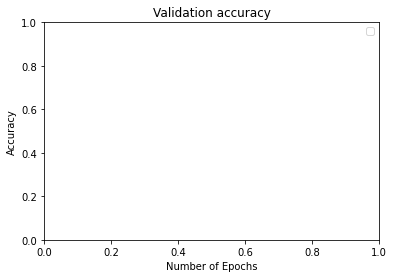

In [88]:
from keras.models import load_model
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
#model.save('8_features_train_test_16.983')
#test 60.691  val 16.983
#model = load_model('8_features_train_test') #val 19%!

acc =tf.keras.metrics.sparse_categorical_accuracy(y_val, model.predict(X_val))
acc.numpy()
print("acc: ", accuracy_score(y_val, acc))


model_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print("Accuracy of the model on test set: {:.3f}%".format(model_acc * 100))



# Plot the accuracy curve for training
#plt.plot(history.history['val_accuracy'], color='r', label="Accuracy")

plt.title("Validation accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
#plt.show()

model_acc = model.evaluate(X_val, y_val, verbose=0)[1]
print("Accuracy of the model on validation set: {:.3f}%".format(model_acc * 100))

acc.shape

In [84]:
# # Training on validation data (Experimental)
# from sklearn.model_selection import train_test_split


# y_val = Data_val.Emotion
# X_val = pd.DataFrame(Data_val.drop(['Emotion', 'User'], axis = 1))

# X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_val, y_val, test_size = 0.3, random_state = 123)


# #Trying adam optimizer
# modelVal = initModelGRU(X.shape[1], 7, 'softmax')
# modelVal.compile(
#     optimizer='adam',
#     loss='sparse_categorical_crossentropy',
#     metrics=['accuracy']
# )

# historyVal = modelVal.fit(
#     X_train_val,
#     y_train_val,
#     validation_data = (X_test_val, y_test_val),
#     epochs=1000,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=100,
#             restore_best_weights=True
#         )
#     ]
# )

# #Result of adam optimizer on validation data
# model_acc = modelVal.evaluate(X_test_val, y_test_val, verbose=0)[1]
# print("Validation Accuracy: {:.3f}%".format(model_acc * 100))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 9, 1)             0         
                                                                 
 gru (GRU)                   (None, 9, 256)            198912    
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 7)                 16135     
                                                                 
Total params: 215,047
Trainable params: 215,047
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
38/38 [==============================

Epoch 107/1000
38/38 [==============================] - 1s 35ms/step - loss: 1.2008 - accuracy: 0.5053 - val_loss: 1.3129 - val_accuracy: 0.4866
Epoch 108/1000
38/38 [==============================] - 1s 37ms/step - loss: 1.1968 - accuracy: 0.5251 - val_loss: 1.2973 - val_accuracy: 0.4789
Epoch 109/1000
38/38 [==============================] - 2s 57ms/step - loss: 1.1777 - accuracy: 0.5136 - val_loss: 1.3076 - val_accuracy: 0.5077
Epoch 110/1000
38/38 [==============================] - 3s 90ms/step - loss: 1.1519 - accuracy: 0.5284 - val_loss: 1.3027 - val_accuracy: 0.5077
Epoch 111/1000
38/38 [==============================] - 4s 103ms/step - loss: 1.1545 - accuracy: 0.5333 - val_loss: 1.3478 - val_accuracy: 0.5096
Epoch 112/1000
38/38 [==============================] - 3s 92ms/step - loss: 1.1566 - accuracy: 0.5202 - val_loss: 1.3114 - val_accuracy: 0.4981
Epoch 113/1000
38/38 [==============================] - 3s 84ms/step - loss: 1.1667 - accuracy: 0.5284 - val_loss: 1.2720 - val_a

38/38 [==============================] - 1s 38ms/step - loss: 0.8975 - accuracy: 0.6255 - val_loss: 1.1933 - val_accuracy: 0.6054
Epoch 220/1000
38/38 [==============================] - 2s 47ms/step - loss: 0.8827 - accuracy: 0.6362 - val_loss: 1.2186 - val_accuracy: 0.5747
Epoch 221/1000
38/38 [==============================] - 4s 109ms/step - loss: 0.8770 - accuracy: 0.6370 - val_loss: 1.2194 - val_accuracy: 0.5690
Epoch 222/1000
38/38 [==============================] - 4s 108ms/step - loss: 0.8879 - accuracy: 0.6354 - val_loss: 1.2194 - val_accuracy: 0.5977
Epoch 223/1000
38/38 [==============================] - 5s 119ms/step - loss: 0.8923 - accuracy: 0.6387 - val_loss: 1.2297 - val_accuracy: 0.5728
Epoch 224/1000
38/38 [==============================] - 3s 79ms/step - loss: 0.8979 - accuracy: 0.6272 - val_loss: 1.2010 - val_accuracy: 0.5690
Epoch 225/1000
38/38 [==============================] - 1s 38ms/step - loss: 0.8750 - accuracy: 0.6263 - val_loss: 1.2033 - val_accuracy: 0.59

38/38 [==============================] - 2s 57ms/step - loss: 0.7569 - accuracy: 0.6741 - val_loss: 1.2542 - val_accuracy: 0.6456
Epoch 332/1000
38/38 [==============================] - 1s 34ms/step - loss: 0.7976 - accuracy: 0.6650 - val_loss: 1.2216 - val_accuracy: 0.6245
Epoch 333/1000
38/38 [==============================] - 1s 34ms/step - loss: 0.7627 - accuracy: 0.6642 - val_loss: 1.2549 - val_accuracy: 0.5977
Epoch 334/1000
38/38 [==============================] - 1s 36ms/step - loss: 0.7383 - accuracy: 0.6724 - val_loss: 1.2573 - val_accuracy: 0.6226
Epoch 335/1000
38/38 [==============================] - 1s 36ms/step - loss: 0.7911 - accuracy: 0.6560 - val_loss: 1.3300 - val_accuracy: 0.5728
Epoch 336/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.7552 - accuracy: 0.6683 - val_loss: 1.2894 - val_accuracy: 0.6111
Epoch 337/1000
38/38 [==============================] - 1s 35ms/step - loss: 0.7837 - accuracy: 0.6708 - val_loss: 1.3041 - val_accuracy: 0.5958


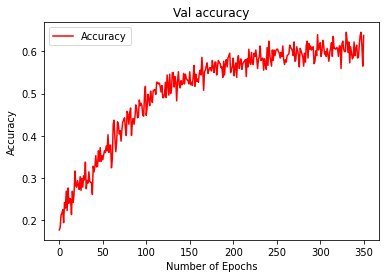

In [85]:
# # Plot the accuracy curve for validation set
# import matplotlib.pyplot as plt
# plt.plot(historyVal.history['val_accuracy'], color='r', label="Accuracy")

# plt.title("Val accuracy")
# plt.xlabel("Number of Epochs")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.show()

In [86]:
# predict = model.predict(X_test)[0]
# predict = [np.argmax(pre) for pre in predict]
# print(predict)
# y_test.head()